In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from RefractiveIndexClass import RefractiveIndex as RI
from DataAnalysisClass import DataHandling as DH

In [3]:
def m2nm(x):
    return x * 1e9

In [4]:
wavelengths = np.linspace(950, 1130, 10000) # [nm]
ZDW = 1280                          # Zero delay wavelngth [nm]
delta = ZDW / 4                     # phase shift
central_wavelength = 1040           # [nm]
sigma = 20                          # Bandwidth
L_f = 0.2                           # Fibre length [m]
L_f = m2nm(L_f)                     # Fibre length [nm]
L_air = - L_f * RI.n_group(RI.n_fs, ZDW) + delta                               # Required air difference for ZDW

# Interfernce
deltaPhi = 2 * np.pi / wavelengths * (L_air  + L_f * RI.n_fs(wavelengths))     # Spectral phase difference
Gaussian = np.exp(- ((wavelengths - central_wavelength)/ sigma)**2)

Text(0.5, 1.0, 'Simulated phase in fused silica')

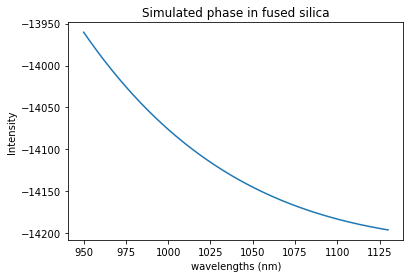

In [5]:
plt.plot(wavelengths, deltaPhi)
plt.xlabel("wavelengths (nm)")
plt.ylabel("Intensity")
plt.title("Simulated phase in fused silica")

In [7]:
import Functions as f
sif = f.SI_Functions()

In [ ]:
#re-defining deltaphiretrievalprocedure here because the one saved in functions was producing a strange plot

c:\Users\molly\OneDrive\Python\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
c:\FYP_Github\Physics-FYP\Functions.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2, 1, 2)
c:\Users\molly\OneDrive\Python\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


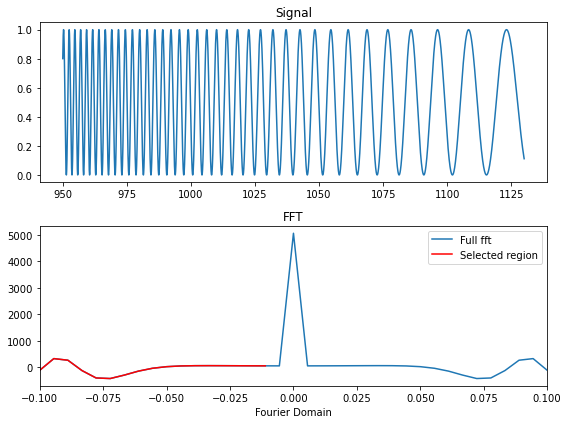

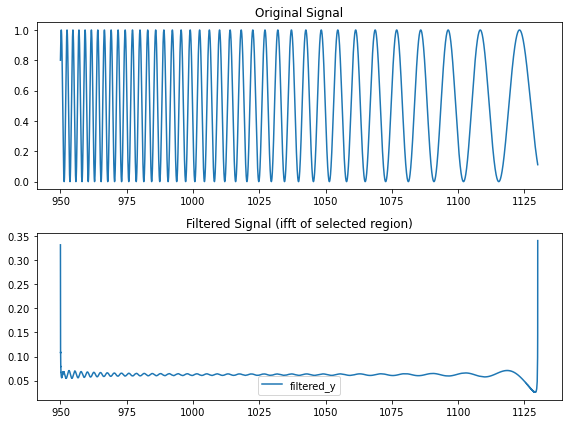

[1.321606   1.15847701 1.13728045 ... 2.13398051 2.12939542 1.92565349]
MIN:  -3.1411185783445603
MAX:  3.1412965722113255
Final ys:
[1.321606   1.15847701 1.13728045 ... 2.13398051 2.12939542 1.92565349]


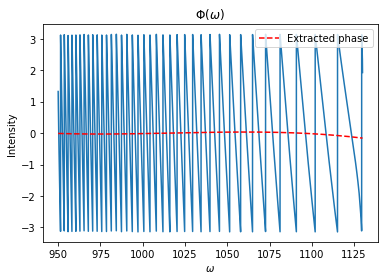

In [10]:
#import simulation data
df = pd.read_csv('simulation-data-1.csv')
x = df["wavelengths[nm]"]
y = df["amplitude"]
coeffs = sif.DeltaPhiRetrievalProcedure(x,y,order=3, keep_min_freq=0.01,keep_max_freq=-1,side = "left", show_plots = True, fft_x_lim = [-0.1, 0.1])[1]

In [13]:
#re-defining deltaphiretrievalprocedure here because the one saved in functions was producing a strange plot
import cmath
def DeltaPhiRetrievalProcedure(x, y, order = 2, keep_min_freq = 0.08, keep_max_freq = -1, side = "left", show_plots = True, fft_x_lim = [-1e-12, 1e-12]):
    # Construct the Fourier Domain
    N = len(x)                      # Number of data points
    T = (max(x) - min(x)) / N       # Sample spacing
    xf = np.fft.fftfreq(N, T)       # Create the Fourier domain
    xf = np.fft.fftshift(xf)        # Shift the domain to be centered around 0

    # Perform the FFT
    yf = np.fft.fft(y)
    yf = np.fft.fftshift(yf)

    # Filter the FFT to keep only the desired frequencies
    if side == "both":
        if keep_max_freq == -1: # Go to max
            idx_left = np.array(np.where(xf < -keep_min_freq)).flatten()                                # left of DC
            idx_right = np.array(np.where(keep_min_freq < xf)).flatten()                                # right of DC
        else:
            idx_left = np.array(np.where((-keep_max_freq < xf) & (xf < -keep_min_freq))).flatten()      # left of DC
            idx_right = np.array(np.where((keep_min_freq < xf) & (xf < keep_max_freq))).flatten()       # right of DC
        idx = (np.concatenate((idx_left, idx_right)))
    elif side == "right":
        if keep_max_freq == -1: # Go to max
            idx = np.array(np.where(keep_min_freq < xf)).flatten()                                # right of DC
        else:
            idx = np.array(np.where((keep_min_freq < xf) & (xf < keep_max_freq))).flatten() 
    elif side == "left":
        if keep_max_freq == -1: # Go to max
            idx = np.array(np.where(xf < -keep_min_freq)).flatten()                                # left of DC                           # right of DC
        else:
            idx = np.array(np.where((-keep_max_freq < xf) & (xf < -keep_min_freq))).flatten()      # left of DC
    else:
        print("'side' is not a valid argument. It should be 'left', 'right', or 'both'.")
        return
    
    # Define the box filter
    box_filter = np.zeros(len(yf), dtype=complex)
    box_filter[idx] = 1
    filtered_fourier_data = yf * box_filter

    # Perform the inverse FFT
    filtered_y = np.fft.ifft(np.fft.ifftshift(filtered_fourier_data))
    print("before scaling")
    print(filtered_y)
    filtered_y_scaled = filtered_y / len(y)
    print("after scaling")
    print(filtered_y_scaled)

    # Plot the FFT results
    if show_plots == True:
        plt.figure(figsize=(8, 6))
        plt.subplot(2, 1, 1)
        plt.plot(x, y)
        plt.title("Signal")
        plt.subplot(2, 1, 2)
        plt.plot(xf, yf, label = "Full fft") # Normalised
        plt.title("FFT")
        plt.xlim(fft_x_lim)  # Limit the x-axis to the positive frequencies
        plt.xlabel("Fourier Domain")
        plt.tight_layout()
        plt.subplot(2, 1, 2)
        if side == "both":
           plt.plot(xf[idx_left], yf[idx_left], color='r', label = "Selected region")
           plt.plot(xf[idx_right], yf[idx_right], color='r')   
        elif side == "right":
            plt.plot(xf[idx], yf[idx], color='r', label = "Selected region")
        elif side == "left":
            plt.plot(xf[idx], yf[idx], color='r', label = "Selected region")
        plt.legend()
        plt.tight_layout()
        plt.show()


        # Plot the original data and the filtered data in the original domain
        plt.figure(figsize=(8, 6))
        plt.subplot(2, 1, 1)
        plt.plot(x, y)
        plt.title("Original Signal")
        plt.subplot(2, 1, 2)
        plt.plot(x, np.abs(filtered_y)**2, label="filtered_y")
        # plt.xlim([np.real(x[np.nonzero(filtered_y)[0][0]]), np.real(x[np.nonzero(filtered_y)[0][-1]])])
        plt.title("Filtered Signal (ifft of selected region)")
        plt.tight_layout()
        plt.legend()
        plt.show()
    


    # Extract phase and unwrap
    final_ys = np.zeros(len(filtered_y))
    for i in range(len(filtered_y)):
        final_ys[i] = cmath.phase((filtered_y[i]))
    final_ys = np.unwrap(final_ys)
    print("final ys no scaling")
    print(final_ys)
    
    
    # Extract phase and unwrap but for scaled version
    #final_ys_scaled = np.zeros(len(filtered_y_scaled))
    final_ys_scaled = np.unwrap(np.angle(filtered_y_scaled))
    # for i in range(len(filtered_y_scaled)):
    #     final_ys_scaled[i] = cmath.phase((filtered_y_scaled[i]))
    # final_ys_scaled = np.unwrap(final_ys)
    print("final ys with scaling")
    print(final_ys_scaled)
    
    # Perform the fit
    coefficients = np.polyfit(x, final_ys, order)

    if show_plots == True:
        plt.plot(x, final_ys)
        plt.title("$\Phi(\omega)$")
        plt.xlabel("$\omega$")
        plt.ylabel("Intensity")
        plt.plot(x, np.polyval(coefficients, x), color='r', linestyle='--', label="Extracted phase")
        # plt.plot(x, -1.95698265e-05*x**3 +   6.79351537e-02*x**2 -7.89563528e+01*x +3.04750604e+04,label="Original simulated phase", color='orange', linestyle = '-.')
        
        plt.legend()
        # plt.xlim([np.real(x[np.nonzero(filtered_y)[0][0]]), np.real(x[np.nonzero(filtered_y)[0][-1]])])
    return [x, coefficients]

before scaling
[ 0.14193548+0.5577479j   0.15222012+0.34801806j  0.16212447+0.35024912j
 ... -0.20067681+0.31783126j -0.20161058+0.32257708j
 -0.20260485+0.54677873j]
after scaling
[ 1.41935480e-05+5.57747899e-05j  1.52220121e-05+3.48018060e-05j
  1.62124467e-05+3.50249119e-05j ... -2.00676815e-05+3.17831260e-05j
 -2.01610577e-05+3.22577085e-05j -2.02604853e-05+5.46778727e-05j]


c:\Users\molly\OneDrive\Python\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
<ipython-input-13-1b724ac0120b>:62: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2, 1, 2)
c:\Users\molly\OneDrive\Python\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


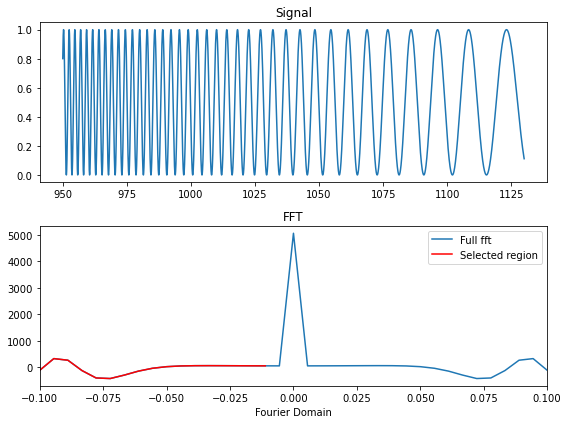

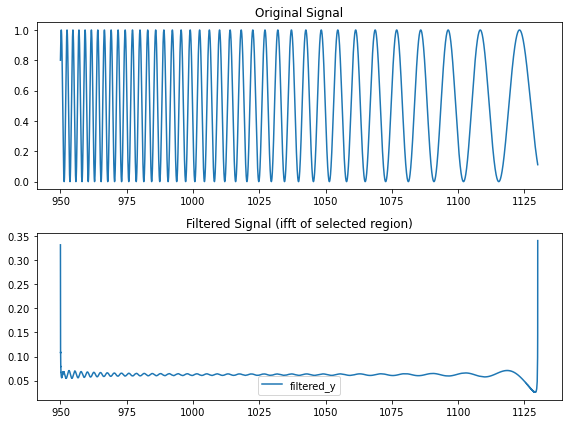

final ys no scaling
[   1.321606      1.15847701    1.13728045 ... -236.62706116 -236.63164626
 -236.83538818]
final ys with scaling
[   1.321606      1.15847701    1.13728045 ... -236.62706116 -236.63164626
 -236.83538818]


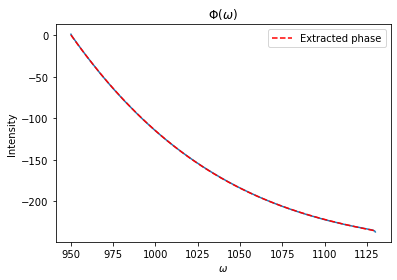

In [14]:
coeffs = DeltaPhiRetrievalProcedure(x,y,order=3, keep_min_freq=0.01,keep_max_freq=-1,side = "left", show_plots = True, fft_x_lim = [-0.1, 0.1])[1]

Don't know why the below isn't working when calling

In [18]:
fitted_line = sif.MakeDeltaPhiLambda(coeffs)
#print(max(fitted_line(wavelengths)))

TypeError: MakeDeltaPhiLambda() takes 1 positional argument but 2 were given

In [21]:
def MakeDeltaPhiLambda(coefficients):
        import sympy as sp
        return lambda var: np.poly1d(coefficients)(var)

In [22]:
fitted_line = MakeDeltaPhiLambda(coeffs)

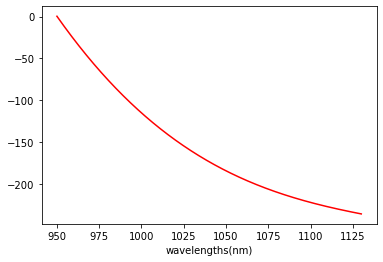

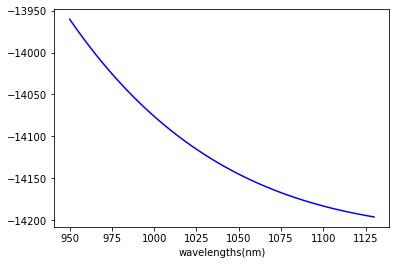

In [23]:
plt.plot(wavelengths,fitted_line(wavelengths),color='r')
plt.xlabel("wavelengths(nm)")
plt.ylabel("")
plt.show()
plt.plot(wavelengths,deltaPhi,color='b')
plt.xlabel("wavelengths(nm)")
plt.ylabel("")
plt.show()

In [24]:
def ObtainBetaFromPhi(phi, length):
    return lambda omegas: [phi(omega) / length for omega in omegas]

def ObtainBetaFromPhi(phi, length):
    return lambda var: phi(var) / length

def Obtain_n(beta):
        return lambda vars: [beta(var) * var / (2 * np.pi) for var in vars]

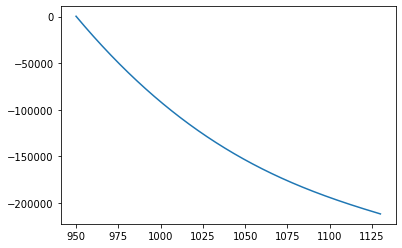

In [25]:
beta = ObtainBetaFromPhi(fitted_line,0.2)
n_eff = Obtain_n(beta)
plt.plot(wavelengths,n_eff(wavelengths))

In [28]:
shifted_deltaPhi = deltaPhi + abs(max(deltaPhi))
coefficients_shifted = np.polyfit(wavelengths,shifted_deltaPhi, deg=3)
fitted_line_shifted = MakeDeltaPhiLambda(coefficients_shifted)
beta_shifted = ObtainBetaFromPhi(fitted_line_shifted,0.2)
new_neff = Obtain_n(beta_shifted)

Text(0.5, 1.0, 'shifted to correct refractive index range')

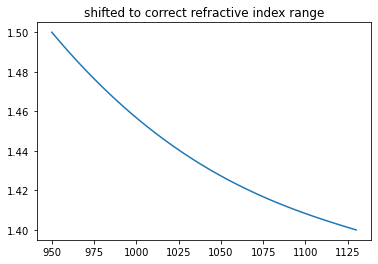

In [30]:
#shift refractive index graph up to be between 1.4 and 1.5 as it should be in this range according to the sellmeier equations
def scale_values(original_values, new_start, new_end):
    original_start = original_values[0]
    original_end = original_values[-1]

    scaled_values = (
        (original_values - original_start) / (original_end - original_start)
    ) * (new_end - new_start) + new_start

    return scaled_values

scaled_refractive_index = scale_values(new_neff(wavelengths),1.5,1.4)
plt.plot(wavelengths,scaled_refractive_index)
plt.title("shifted to correct refractive index range")

The phase definitely needs to be adjusted / shifted somehow before we go on to calculate beta and refractive index and everything as it all depends on the phase.

Going to work backwards as we know the refractive index of fused silica in this wavelength range should lie within 1.4 and 1.5 ish, so going to work back to get phi and see what range it should take.

In [31]:
#what are the coefficients for this line as this would be the lambda function for n_eff which could then convert to get lambda function for beta and therefore phi
n_eff_coeffs = np.polyfit(wavelengths,scaled_refractive_index,deg=3)
#make lambda function
n_eff_coeffs

array([-5.05567864e-09,  1.79741820e-05, -2.14962371e-02,  1.00344485e+01])

In [37]:
#working backwards

def Make_n_effLambda(coefficients): #make the refractive index a lambda function so we can use it below to extract the correct phase
        import sympy as sp
        return lambda var: np.poly1d(coefficients)(var)
    
fitted_line_correct_n = Make_n_effLambda(n_eff_coeffs)

def Obtain_beta_from_n(n):
        return lambda vars: [(2 * np.pi * n(var) / var) for var in vars]

Text(0.5, 1.0, 'Correct beta')

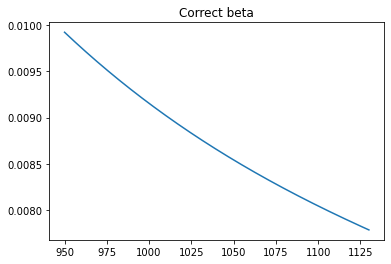

In [48]:
beta_correct = Obtain_beta_from_n(fitted_line_correct_n)
beta_correct
plt.plot(wavelengths,beta_correct(wavelengths))
plt.title("Correct beta")

In [49]:
def ObtainPhiFromBeta(beta, length): #re-arranging equation for phi
    return lambda omegas: [beta(omega) * length for omega in omegas]

In [50]:
phi_correct = ObtainPhiFromBeta(beta_correct,0.2)
phi_correct

<function __main__.ObtainPhiFromBeta.<locals>.<lambda>(omegas)>

In [51]:
plt.plot(wavelengths,phi_correct(wavelengths))

TypeError: 'numpy.float64' object is not iterable

# Cannot figure out why this is returning an error